# Obligatorio - Taller Agentes Inteligentes 2025

En este trabajo obligatorio aplicaremos los conceptos vistos en el curso para dise√±ar, implementar y evaluar agentes capaces de aprender a jugar al cl√°sico **Breakout** de Atari, utilizando el entorno provisto por Farama Gymnasium ([https://ale.farama.org/environments/breakout/](https://ale.farama.org/environments/breakout/)). 

<p align="center">
  <img src="https://media.tenor.com/oMxHgRrISJsAAAAM/atari-deep-learning.gif" alt="Atari Deep Learning"/>
</p>


El ejercicio se enmarca en un contexto de aprendizaje pr√°ctico, donde trabajaremos con las interfaces est√°ndar de Gymnasium para:

1. **Profundizar en algoritmos de valor**: implementaremos y compararemos dos variantes de Q-Learning basadas en redes neuronales profundas:
   * **Deep Q Learning (DQN)**
   * **Double Deep Q Learning (DDQN)**
2. **Evaluar rendimiento y estabilidad**: registraremos las recompensas obtenidas durante el entrenamiento de cada agente y analizaremos su comportamiento mediante gr√°ficas comparativas.
3. **Demostrar resultados de forma visual**: capturaremos v√≠deos que muestren a cada agente ‚Äúresolviendo‚Äù el entorno, entendido como la habilidad de romper al menos cinco bloques en una partida.

Debido a las limitaciones de tiempo y c√≥mputo propias de un entorno de curso, no se espera entrenar modelos durante m√°s de diez horas por agente. Por ello, ser√° fundamental:

* Integrar puntos de **checkpoint** para guardar peri√≥dicamente los pesos de la red.
* Seguir en los puntos 2 y 3 la arquitectura y t√©cnicas originales propuestas en los papers seminales de DQN y DDQN, dejando la experimentaci√≥n adicional para el punto extra.
* Flexibilizar la notebook de gu√≠a: pueden reorganizarla o dividirla en m√∫ltiples archivos seg√∫n su conveniencia.


## Objetivos y tareas

1. **Completar la implementaci√≥n**
   * Rellenar el c√≥digo faltante en la notebook y en los m√≥dulos auxiliares para que los agentes puedan interactuar con el entorno de Breakout.
2. **Entrenar agentes**
   * Ajustar y entrenar un **DQN** que alcance la condici√≥n de ‚Äúresolver‚Äù (romper ‚â• 10 bloques).
   * Ajustar y entrenar un **DDQN** con la misma meta de desempe√±o.
3. **Visualizar y analizar resultados**
   * Generar **gr√°ficas comparativas** de las recompensas obtenidas por ambos agentes en el mismo entorno (una gr√°fica por ambiente). Adem√°s se sugiere gr√°ficas que muestren el valor de la funci√≥n de valor Q para cada agente.
   * Extraer **al menos dos conclusiones** por gr√°fica, comentando diferencias en convergencia, estabilidad y comportamiento exploratorio.
4. **Registro de demostraciones**
   * Grabar y entregar un **video demostrativo** de cada agente resolviendo el entorno.
5. **Experimentaci√≥n**
   * Probar otras arquitecturas, t√©cnicas de mejora o m√≥dulos de procesamiento de entradas m√°s avanzados, documentando brevemente su impacto/

## Criterios de evaluaci√≥n

| Criterio                                  | Descripci√≥n                                                  | Peso |
| ----------------------------------------- | ------------------------------------------------------------ | ---- |
| **Implementaci√≥n y rendimiento**          | DQN y DDQN completados; cada agente rompe ‚â• 10 bloques       | 40%  |
| **Estructura y narrativa de la notebook** | Secciones claras, explicaci√≥n de decisiones, ‚Äúhistoria‚Äù      | 20%  |
| **An√°lisis de resultados**                | Gr√°ficas comparativas; ‚â• 2 conclusiones por gr√°fico          | 20%  |
| **Presentaci√≥n visual**                   | V√≠deos demostrativos de cada agente                          | 10%  |
| **Experimentaci√≥n**                       | Experimentaci√≥n adicional documentada y analizada brevemente | 10%  |

## Bibliograf√≠a

* **Mnih, V.**, Kavukcuoglu, K., Silver, D., Rusu, A. A., Veness, J., Bellemare, M. G., ‚Ä¶ Hassabis, D. (2013). *Playing Atari with Deep Reinforcement Learning*. [arXiv:1312.5602](https://arxiv.org/abs/1312.5602)
* **van Hasselt, H.**, Guez, A., & Silver, D. (2015). *Deep Reinforcement Learning with Double Q-learning*. [arXiv:1509.06461](https://arxiv.org/abs/1509.06461)
* **Sutton, R. S.**, & Barto, A. G. (2018). *Reinforcement Learning: An Introduction* (2nd ed.), cap√≠tulo 16.5: ‚ÄúHuman-level Video Game Play‚Äù. MIT Press.

# Import from github

In [1]:
# !git clone https://github.com/nataliacampiglia/obligatorio-taller-ia.git
# %cd obligatorio-taller-ia
# !git pull
#!git checkout nati-branch-master

## Setup

**Imports**

In [2]:
#!pip install torchinfo

In [3]:
import os
import torch
import numpy as np
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
import gymnasium
import ale_py
from utils import make_env, show_observation_stack
from IPython.display import Video


#Import Constants

In [ ]:
from constants import (PHASE1_MODEL_PATH, COMMON_METRICS_PATH, COMMON_MODEL_PATH)

ALE (Atari Learning Environment) es un entorno de aprendizaje para videojuegos de Atari. En este caso, utilizaremos el entorno de Breakout. Es necesario entender que se separa el entorno de los roms de Atari, que son los juegos en s√≠. El entorno de ALE permite interactuar con los juegos de Atari a trav√©s de una API est√°ndar, facilitando la implementaci√≥n de algoritmos de aprendizaje por refuerzo.

Debemos instalar los roms por separado, para ello primero tenemos que saber donde est√°n los roms de Atari. 

In [4]:
gymnasium.register_envs(ale_py) # registramos todos los entornos de ale_py
ruta_init = ale_py.roms.__file__ # debemos saber donde se encuentra la carpeta roms
ALE_ROMS_PATH = os.path.dirname(ruta_init)
print(ALE_ROMS_PATH)

/opt/miniconda3/envs/obl_taller_ia/lib/python3.12/site-packages/ale_py/roms


Podemos usar los siguientes comando para instalar los roms y colocalos en la carpeta correcta.

In [5]:
# !pip install "autorom[accept-rom-license]"
# !AutoROM --accept-license --install-dir {ALE_ROMS_PATH}

Fijamos la semilla para que los resultados sean reproducibles

In [6]:
SEED = 23

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic=True # https://discuss.pytorch.org/t/what-is-the-differenc-between-cudnn-deterministic-and-cudnn-benchmark/38054
torch.backends.cudnn.benchmark=True # https://discuss.pytorch.org/t/what-does-torch-backends-cudnn-benchmark-do/5936/4
np.random.seed(SEED)
random.seed(SEED)

Vemos que dispositivo tenemos, si es GPU, MPS o CPU. **El uso de GPU es altamente recomendable** para acelerar el entrenamiento de los modelos. 

In [7]:
# Algunas constantes

# definimos el dispositivo que vamos a usar
DEVICE = "cpu"  # por defecto, usamos la CPU
if torch.cuda.is_available():
    DEVICE = "cuda"  # si hay GPU, usamos la GPU
elif torch.backends.mps.is_available():
    DEVICE = "mps"  # si no hay GPU, pero hay MPS, usamos MPS

print(f"Device: {DEVICE}")

Device: mps


## Preprocesando Atari

Para reproducir fielmente el enfoque de Mnih et al. (2013) y reducir la carga computacional al trabajar con im√°genes de Atari (210 √ó 160 p√≠xeles, 128 colores), aplicamos el siguiente preprocesado œÜ a las √∫ltimas **4** frames del entorno:

1. **Conversi√≥n a escala de grises**
   Eliminamos la informaci√≥n de color (GRAYSCALE = True), pues la luminosidad es suficiente para capturar la din√°mica de juego y reduce dr√°sticamente la dimensionalidad de la entrada.

2. **Down-sampling y recorte**
   * Redimensionamos la imagen original a 110 √ó 84 p√≠xeles, manteniendo la proporci√≥n horizontal.
   * Recortamos un √°rea central de 84 √ó 84 p√≠xeles que contiene la ‚Äúzona de juego‚Äù, descartando bordes innecesarios.
     Este paso (SCREEN_SIZE = 84) no solo concentra la atenci√≥n del modelo en la regi√≥n relevante, sino que tambi√©n garantiza un tama√±o cuadrado compatible con las implementaciones de convoluciones en GPU.

3. **Saltos temporales (frame skipping)**
   Procesamos cada 4 frames (SKIP_FRAMES = 4), repitiendo la misma acci√≥n durante esos pasos. Esto reduce la redundancia temporal, acelera el entrenamiento y mantiene la coherencia del movimiento de la paleta y la bola.

4. **Apilamiento de frames**
   Finalmente, acumulamos las √∫ltimas 4 im√°genes preprocesadas (NUM_STACKED_FRAMES = 4) en un √∫nico tensor de entrada. As√≠ el agente puede inferir la velocidad y direcci√≥n de los elementos m√≥viles a partir de la diferencia entre frames.

Este esquema de preprocesado es fundamental para disminuir el espacio de entrada, acelerar las convoluciones y proporcionar al Q-net una representaci√≥n compacta y rica en informaci√≥n din√°mica, tal como se describe en el algoritmo 1 del paper original .

> Se recomienda ver el m√©todo `make_env` en el archivo `utils.py` para entender c√≥mo se implementa este preprocesado. 

In [8]:
GRAY_SCALE = True # si True, convertimos la imagen a escala de grises
SCREEN_SIZE = 84 # redimensionamos a SCREEN_SIZExSCREEN_SIZE
NUM_STACKED_FRAMES = 4 # apilamos NUM_STACKED_FRAMES frames
SKIP_FRAMES = 4 # saltamos SKIP_FRAMES frames (haciendo la misma acci√≥n)

A.L.E: Arcade Learning Environment (version 0.10.2+unknown)
[Powered by Stella]
Game console created:
  ROM file:  /opt/miniconda3/envs/obl_taller_ia/lib/python3.12/site-packages/ale_py/roms/breakout.bin
  Cart Name: Breakout - Breakaway IV (1978) (Atari)
  Cart MD5:  f34f08e5eb96e500e851a80be3277a56
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is -817909848
/opt/miniconda3/envs/obl_taller_ia/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /Users/nataliacampigliastemphelet/master/obligatorio-taller-ia/videos/random folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


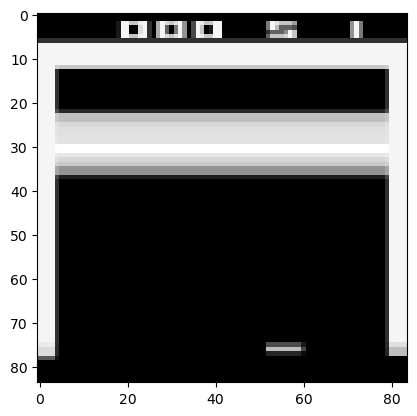

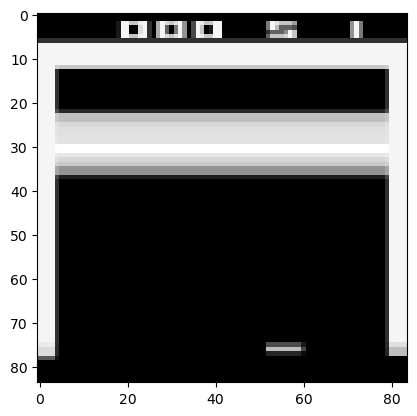

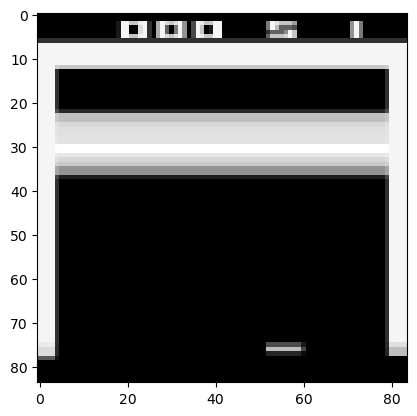

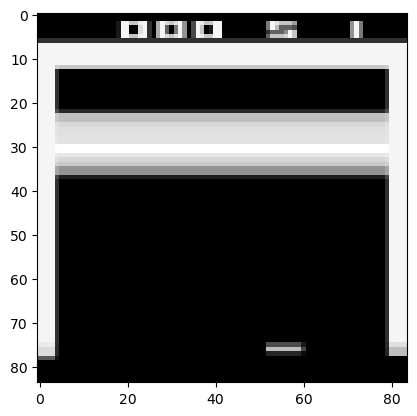

Episode 1 finished with total reward: 2


In [9]:
# https://ale.farama.org/environments/breakout/
ENV_NAME = "ALE/Breakout-v5" 

env = make_env(ENV_NAME,
                video_folder='./videos/random',
                name_prefix="breakout",
                record_every=1,
                grayscale=GRAY_SCALE,
                screen_size=SCREEN_SIZE,
                stack_frames=NUM_STACKED_FRAMES,
                skip_frames=SKIP_FRAMES
                )

for episode_num in range(1):
    obs, info = env.reset()
    show_observation_stack(obs)
    reward_total = 0
    episode_over = False
    while not episode_over:
        action = env.action_space.sample()  # seleccionamos una acci√≥n aleatoria
        obs, reward, terminated, truncated, info = env.step(action)
        reward_total += reward
        episode_over = terminated or truncated
    print(f"Episode {episode_num + 1} finished with total reward: {reward_total}")

env.close()

Adem√°s, podemos mostrar los videos capturados por el entorno de Atari de la siguiente manera:

In [10]:
# Ruta al archivo de v√≠deo en tu sistema de ficheros
video_path = "./videos/random/breakout-episode-0.mp4"

# Muestra el v√≠deo
Video(video_path, embed=True, width=600)

# Exploraci√≥n del entorno

In [11]:
print("Actions shape:",env.action_space)
print("Observation shape:",env.observation_space.shape)
env.reset()
next_state, reward, terminated, truncated, info = env.step(action=0)

print(f"{next_state.shape},\n {reward},\n {terminated},\n {info}")

Actions shape: Discrete(4)
Observation shape: (4, 84, 84)
(4, 84, 84),
 0,
 False,
 {'lives': 5, 'episode_frame_number': 7, 'frame_number': 943}


### Acciones
...

### Observaciones
...

# Deep Q Learning

Deep Q Learning extiende el algoritmo cl√°sico de Q-learning al emplear una **red neuronal profunda** como aproximador de la funci√≥n de valor $Q(s,a)$. Inspirado en Mnih et al. (2013), este m√©todo utiliza una **red convolucional** para procesar directamente las im√°genes del entorno Atari, un **replay buffer** para romper la correlaci√≥n temporal de las muestras. La pol√≠tica sigue un esquema **Œµ-greedy**, balanceando exploraci√≥n y explotaci√≥n, y se entrena minimizando el error de la ecuaci√≥n de Bellman sobre lotes de transiciones muestreadas de manera aleatoria.

<p align="center">
  <img src="https://www.researchgate.net/profile/Faris-Mismar/publication/327045314/figure/fig4/AS:819677282455553@1572437701142/Structure-of-the-neural-network-used-for-the-Deep-Q-learning-Network-implementation-with.png" alt="DQN"/>
</p>

Fuente: [arXiv:1312.5602](https://arxiv.org/abs/1312.5602)

## Memoria

El algoritmo de Deep Q Learning presentado en el paper utiliza una memoria (llamada Replay Memory) para almacenar transiciones pasadas. Tuplas que contienen un estado base, la accion tomada, la recompensa obtenida, una bandera que indica si el siguiente estado es final o no; y el estado siguiente.

Esta memoria es circular, es decir, tiene un l√≠mite maximo de elementos y una vez est√© llena comienza a reemplazar los elementos m√°s viejos.

Vamos a necesitar crear una funci√≥n **sample** que obtiene una mustra aleatoria de elementos de la memoria.  Esto puede ser una lista de Transiciones o listas separadas (pero alineadas) de los elementos que las componen.


> Para implementar esta funcionalidad se debe modificar el archivo **replay_memory.py**

In [12]:
from replay_memory import ReplayMemory, Transition

# Creamos la memoria de repetici√≥n
replay_memory = ReplayMemory(3, DEVICE)

# A√±adimos transiciones a la memoria (solo las 3 √∫ltimas se guardan)
replay_memory.add(0, 'action1', 'reward1', 'done1', 'next_state1' )
replay_memory.add(1, 'action2', 'reward2', 'done2', 'next_state2')
replay_memory.add(2, 'action3', 'reward3', 'done3', 'next_state3')
replay_memory.add(3, 'action4', 'reward4', 'done4', 'next_state4')

# Mostramos el tama√±o de la memoria
print(f"Memory size: {len(replay_memory)}\n")

# Mostramos un sample de la memoria
sampled = replay_memory.sample(2)
print(f"Memory sample:")
for i, sample in enumerate(sampled):
    print(f"Sample {i}: {sample}")


Memory size: 3

Memory sample:
Sample 0: Transition(state=1, action='action2', reward='reward2', done='done2', next_state='next_state2')
Sample 1: Transition(state=3, action='action4', reward='reward4', done='done4', next_state='next_state4')


## Modelo

Vamos a usar un mismo modelo FeedForward para estos dos problemas (entrenado en cada problema particular). Recomendamos simplicidad en la creaci√≥n del mismo, pero tienen total libertad al momento de implementarlo.

> Para implementar esta funcionalidad se debe modificar el archivo **dqn_cnn_model.py**. Se recomienda empezar por una arquitectura simple como la que se muestra en el paper de Mnih et al. (2013) y luego experimentar con arquitecturas m√°s complejas.

In [13]:
from dqn_cnn_model import DQN_CNN_Model

env = make_env(ENV_NAME,
                record_every=None,
                grayscale=GRAY_SCALE,
                screen_size=SCREEN_SIZE,
                stack_frames=NUM_STACKED_FRAMES,
                skip_frames=SKIP_FRAMES
                )
print("Actions shape:",env.action_space)
print("Observatiion shape:",env.observation_space.shape)

env.close()

cnn_model = DQN_CNN_Model(env.observation_space.shape, env.action_space.n).to(DEVICE)
summary(cnn_model, input_size=(32, SKIP_FRAMES, SCREEN_SIZE, SCREEN_SIZE), device=DEVICE) # 32 es el batch size

Actions shape: Discrete(4)
Observatiion shape: (4, 84, 84)


A.L.E: Arcade Learning Environment (version 0.10.2+unknown)
[Powered by Stella]
Game console created:
  ROM file:  /opt/miniconda3/envs/obl_taller_ia/lib/python3.12/site-packages/ale_py/roms/breakout.bin
  Cart Name: Breakout - Breakaway IV (1978) (Atari)
  Cart MD5:  f34f08e5eb96e500e851a80be3277a56
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is -108885961
/opt/miniconda3/envs/obl_taller_ia/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:416: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.warn("Unable to save last video! Did you call close()?")


Layer (type:depth-idx)                   Output Shape              Param #
DQN_CNN_Model                            [32, 4]                   --
‚îú‚îÄConv2d: 1-1                            [32, 16, 20, 20]          4,112
‚îú‚îÄConv2d: 1-2                            [32, 32, 9, 9]            8,224
‚îú‚îÄLinear: 1-3                            [32, 256]                 663,808
‚îú‚îÄLinear: 1-4                            [32, 4]                   1,028
Total params: 677,172
Trainable params: 677,172
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 95.22
Input size (MB): 3.61
Forward/backward pass size (MB): 2.37
Params size (MB): 2.71
Estimated Total Size (MB): 8.69

La red esta definida para que reciba un tensor de 4 dimensiones (batch_size, num_frames, height, width) y devuelve un tensor de 2 dimensiones (batch_size, num_actions). La funci√≥n `forward` es la encargada de definir el flujo de datos a trav√©s de la red. En este caso, se utiliza una red convolucional seguida de capas totalmente conectadas

In [14]:
obs_tensor_batch = torch.rand((NUM_STACKED_FRAMES,SCREEN_SIZE,SCREEN_SIZE)).unsqueeze(0).to(DEVICE) # A√±adimos una dimensi√≥n para el batch y lo pasamos al dispositivo
print(f"Q-values shape: {cnn_model(obs_tensor_batch).shape}") # shape: (1, num_actions) 

Q-values shape: torch.Size([1, 4])


Los valores de Q se obtienen a partir de la salida de la red, cada columna representa el valor Q para cada acci√≥n posible en el estado actual. 

In [15]:
cnn_model(obs_tensor_batch) 

tensor([[-0.0188,  0.0008,  0.0328,  0.0380]], device='mps:0',
       grad_fn=<LinearBackward0>)

Podemos preguntar cu√°l es la acci√≥n con mayor valor Q en un estado.

In [16]:
cnn_model(obs_tensor_batch).max(1)

torch.return_types.max(
values=tensor([0.0380], device='mps:0', grad_fn=<MaxBackward0>),
indices=tensor([3], device='mps:0'))

En el siguiente ejemplo vamos a ver c√≥mo tomar los valores de acciones deseables para un conjunto de estados. 

In [17]:
# Creamos 3 observaciones aleatorias para probar el modelo
obs_ran1 = torch.rand(4, 84, 84)
obs_ran2 = torch.rand(4, 84, 84)
obs_ran3 = torch.rand(4, 84, 84)

batch = torch.stack([obs_ran1, obs_ran2, obs_ran3], dim=0).to(DEVICE) # shape: (3, 4, 84, 84)
print(f"Batch shape: {batch.shape}")

actions =  torch.tensor([1, 2, 3], device=DEVICE).unsqueeze(1) # queremos la acci√≥n 1 para la primera observaci√≥n, la acci√≥n 2 para la segunda y la acci√≥n 3 para la tercera

Q_test = cnn_model(batch)
print(f"Q-values: {Q_test}")
print(f"Q-values: {Q_test.gather(1, actions)}") # https://pytorch.org/docs/main/generated/torch.gather.html

Batch shape: torch.Size([3, 4, 84, 84])
Q-values: tensor([[-0.0399,  0.0014,  0.0332,  0.0316],
        [-0.0319,  0.0112,  0.0292,  0.0156],
        [-0.0356,  0.0033,  0.0296,  0.0224]], device='mps:0',
       grad_fn=<LinearBackward0>)
Q-values: tensor([[0.0014],
        [0.0292],
        [0.0224]], device='mps:0', grad_fn=<GatherBackward0>)


## Phi 

La funci√≥n para procesar los estados (phi en el paper) que es necesaria para poder usar el modelo de Pytorch con las representaciones de gym. Esta funci√≥n pasa una observaci√≥n de gym a un tensor de Pytorch y la normaliza.

> T√©cnicamente la funci√≥n phi tiene m√°s responsabilidades, como la de apilar los frames y el downsampling. En nuestro caso se lo delegamos a los wrappers de gymnasium.

In [18]:
def process_state(obs):
    """
    Preprocess the state to be used as input for the model (transform to tensor).
    """
    return torch.tensor(obs, dtype=torch.float32, device=DEVICE) / 255.0

obs, _ = env.reset()
obs_tensor = process_state(obs)
print(f"Observation shape: {obs_tensor.shape}")

Observation shape: torch.Size([4, 84, 84])


## Agente

Vamos a definir una clase agente (abstracto), encargado de interactuar con el ambiente y entrenar los modelos. Los m√©tdos definidos deben funcionar para ambos problemas simplemente cambiando el modelo a utilizar para cada ambiente.

Abajo dejamos un esqueleto del mismo y las funciones a completar. Recomendamos no alterar la estructura del mismo, pero pueden definir las funciones auxiliares que consideren necesarias.

> Para implementar esta funcionalidad se debe modificar los archivos **abstract_agent.py** y **dqn_agent.py**.

Funciones a completar:


1. **init**: que inicializa los parametros del agente.

2. **compute_epsilon**: que computa el valor actual de epsilon en base al n√∫mero de pasos actuales y si esta entrenando o no.

3. **select_action**: Seleccionando acciones "epsilongreedy-mente" si estamos entranando y completamente greedy en otro caso.

4. **train**: que entrena el agente por un n√∫mero dado de episodios de largo determinado.

5. **record_test_episode**: para grabar un episodio con el agente siempre seleccionando la mejor accion conocida.

## Entrenamiento

# Entrenamiento Progresivo de un Agente DQN en Breakout

En esta secci√≥n del obligatorio implementamos un agente basado en Deep Q-Network (DQN) para resolver el entorno **Breakout** de Atari.

El objetivo es demostrar progresivamente c√≥mo el agente mejora su rendimiento a trav√©s de fases de entrenamiento, visualizaci√≥n de m√©tricas y evaluaci√≥n.

## 1. Preparaci√≥n del entorno y del agente

Comenzamos creando el entorno y nuestro agente DQN, basado en una red convolucional. Definimos los hiperpar√°metros iniciales que guiar√°n su comportamiento durante el entrenamiento.

Este paso es como presentar a nuestro protagonista antes de su viaje.

### Hiperpar√°metros fijos durante todo el entrenamiento

In [19]:
BATCH_SIZE = 32
BUFFER_SIZE = 30_000
EPISODE_BLOCK = 100
LEARNING_RATE = 1e-5
STEPS_PER_EPISODE = 20_000
GAMMA = 0.995

### Hiperpar√°metros variables durante el entrenamiento

In [20]:
TOTAL_STEPS = 100_000
EPISODES = 10_000
EPSILON_INI = 1
EPSILON_MIN = 0.3
EPSILON_ANNEAL_STEPS = 80_000


### Creamos el entorno
Creamos una funcion axuliar para crear el entorno mas facilment

In [29]:
# env = make_env(ENV_NAME,
#                 video_folder='./videos/dqn_training-initial',
#                 name_prefix="breakout",
#                 record_every=500,
#                 grayscale=GRAY_SCALE,
#                 screen_size=SCREEN_SIZE,
#                 stack_frames=NUM_STACKED_FRAMES,
#                 skip_frames=SKIP_FRAMES
#                 )

from load_and_evaluate import create_env
env = create_env(video_folder='./videos/dqn_training-initial2')

A.L.E: Arcade Learning Environment (version 0.10.2+unknown)
[Powered by Stella]
Game console created:
  ROM file:  /opt/miniconda3/envs/obl_taller_ia/lib/python3.12/site-packages/ale_py/roms/breakout.bin
  Cart Name: Breakout - Breakaway IV (1978) (Atari)
  Cart MD5:  f34f08e5eb96e500e851a80be3277a56
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is 1866383761


## 2. Primeros pasos de aprendizaje

En esta etapa inicial, el agente comienza su proceso de entrenamiento enfrent√°ndose al entorno por primera vez. Ejecutamos un bloque limitado a **100.000 pasos**, con el objetivo principal de que el agente **explore intensamente** en lugar de tratar de maximizar recompensas desde el principio.

Para fomentar esta exploraci√≥n, configuramos el par√°metro `epsilon` ‚Äîque controla la probabilidad de tomar acciones aleatorias‚Äî con los siguientes valores:

- `EPSILON_INI = 1.0`: al inicio, el agente toma decisiones completamente al azar.
- `EPSILON_MIN = 0.3`: al final del bloque, a√∫n mantiene un 30% de exploraci√≥n para evitar caer en pol√≠ticas sub√≥ptimas demasiado pronto.

Este enfoque permite que el agente **cometa errores**, **pruebe diferentes estrategias** y **recolecte una variedad de experiencias** √∫tiles que luego ser√°n aprovechadas durante el entrenamiento.

En esta fase **no esperamos que el agente sea bueno todav√≠a**. De hecho, probablemente falle con frecuencia. Sin embargo, es aqu√≠ donde empieza a identificar patrones b√°sicos del entorno ‚Äîcomo la relaci√≥n entre sus acciones y las recompensas‚Äî, sentando las bases para mejorar en etapas posteriores.

In [22]:
%load_ext autoreload
%autoreload 2
import importlib
import replay_memory  # or whatever module you changed
import dqn_cnn_model
import dqn_agent
import abstract_agent
import torch
importlib.reload(replay_memory)
importlib.reload(dqn_cnn_model)
importlib.reload(dqn_agent)
importlib.reload(abstract_agent)
from dqn_cnn_model import DQN_CNN_Model
from dqn_agent import DQNAgent

from abstract_agent import Agent

### Creamos la policy_net

In [23]:
net = DQN_CNN_Model(env.observation_space.shape, env.action_space.n).to(DEVICE)

In [24]:
# # Cargar los pesos guardados
# net.load_state_dict(torch.load("net_history/GenericDQNAgent-run:run2-reichel-steps:1000001-e:0.0500-max_r:13.36.dat"))

### Inicializamos el DQN Agent


In [30]:
RUN_NAME="initial_run"
dqn_agent = DQNAgent(env, net, process_state, BUFFER_SIZE, BATCH_SIZE, LEARNING_RATE, GAMMA, epsilon_i=EPSILON_INI, epsilon_f=EPSILON_MIN, epsilon_anneal_steps=EPSILON_ANNEAL_STEPS, episode_block=EPISODE_BLOCK, device=DEVICE, run_name=RUN_NAME)

In [ ]:
dqn_rewards = dqn_agent.train(EPISODES, STEPS_PER_EPISODE, TOTAL_STEPS, PHASE1_MODEL_PATH)
env.close()

Entrenando:   0%|          | 0/10000 [00:00<?, ?episode/s]

Iniciando entrenamiento...


/opt/miniconda3/envs/obl_taller_ia/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda3/envs/obl_taller_ia/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Entrenando:   1%|‚ñè         | 143/10000 [1:19:30<91:20:34, 33.36s/episode, reward=1.24, epsilon=0.762, steps=27162]  


KeyboardInterrupt: 

### Visualizar m√©tricas

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


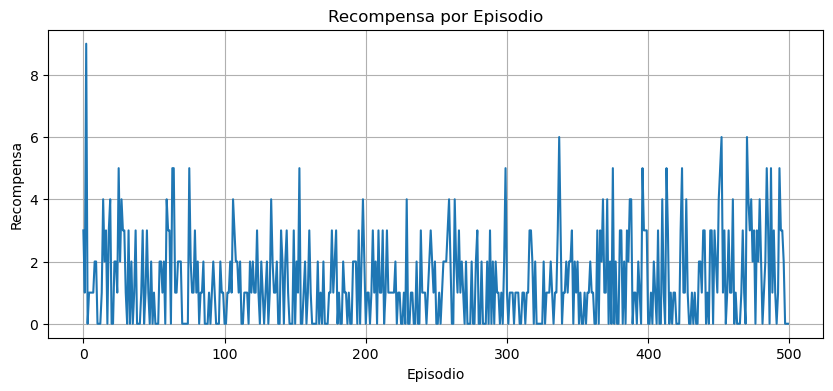

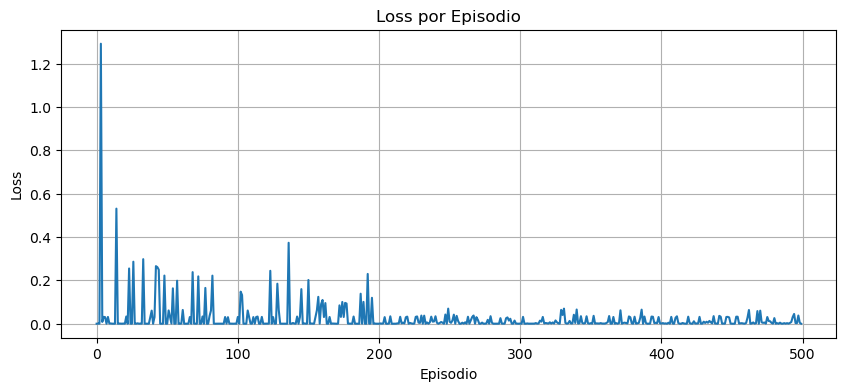

In [ ]:
%load_ext autoreload
%autoreload 2
from utils import graph_metrics

METRICS_PATH = f"{COMMON_METRICS_PATH}{RUN_NAME}.npz"
graph_metrics(pathname=METRICS_PATH)

## 3. Fase 2 de entrenamiento: Aprendizaje b√°sico

Luego de la exploraci√≥n inicial, el agente ya ha tenido contacto con el entorno y comenz√≥ a identificar patrones b√°sicos de acci√≥n y recompensa. En esta segunda fase, extendemos el entrenamiento a **500.000 pasos**, con el objetivo de que el agente comience a **refinar sus decisiones** y desarrolle pol√≠ticas m√°s efectivas.

En esta etapa ya no se explora al azar completamente. En cambio, **se busca un balance entre exploraci√≥n y explotaci√≥n**: permitir al agente seguir probando nuevas acciones, pero tambi√©n comenzar a confiar m√°s en lo que ha aprendido.

Por eso, ajustamos el par√°metro `epsilon` de la siguiente manera:

- `EPSILON_INI = 0.3`: el agente ya no act√∫a completamente al azar, pero a√∫n explora activamente.
- `EPSILON_MIN = 0.05`: al final del bloque, la exploraci√≥n se reduce significativamente, permitiendo una mayor explotaci√≥n.
- `EPSILON_ANNEAL_STEPS = 300_000`: la reducci√≥n se hace de forma gradual durante la mayor parte del bloque.

Durante esta fase, **esperamos observar una mejora clara en el rendimiento**:
- Aumento progresivo en la recompensa media.
- Episodios m√°s largos (el agente sobrevive m√°s).
- Menor p√©rdida (loss), reflejando una mejor aproximaci√≥n de los valores Q.

Esta fase es clave para que el agente **consolide lo aprendido** y empiece a mostrar un comportamiento m√°s coherente, orientado a maximizar la recompensa.

In [ ]:
TOTAL_STEPS = 500_000
EPISODES = 10_000
EPSILON_INI = 0.3
EPSILON_MIN = 0.05
EPSILON_ANNEAL_STEPS = 300_000

# Uso de funciones axuliares
De ahora en maz vamos a usar funciones axuliares que haran lo mismo que vemos en la face 1.


LLamamos a la funcion externa load_dqn_agent, donde creamos la policy_net, cargamos los pesos guardados y inicializamos el DQN Agent

from load_and_evaluate import load_dqn_agent
dqn_agent = load_dqn_agent()

In [ ]:
# Reload to detect changes
import load_and_evaluate
import importlib
importlib.reload(load_and_evaluate)

from load_and_evaluate import create_env, load_dqn_agent

In [34]:
PHASE = 'phase2'

In [37]:
VIDEO_FOLDER = f"./videos/dqn_training_{PHASE}"
env = create_env(video_folder=VIDEO_FOLDER)

./videos/dqn_training_phase2


A.L.E: Arcade Learning Environment (version 0.10.2+unknown)
[Powered by Stella]
Game console created:
  ROM file:  /opt/miniconda3/envs/obl_taller_ia/lib/python3.12/site-packages/ale_py/roms/breakout.bin
  Cart Name: Breakout - Breakaway IV (1978) (Atari)
  Cart MD5:  f34f08e5eb96e500e851a80be3277a56
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is -341962827
/opt/miniconda3/envs/obl_taller_ia/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /Users/nataliacampigliastemphelet/master/obligatorio-taller-ia/videos/dqn_training_phase2 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [38]:
# Creamos agente dqn
RUN_NAME=f"{PHASE}_run"
dqn_agent = load_dqn_agent(env,loadPath=PHASE1_MODEL_PATH, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, learning_rate=LEARNING_RATE, gamma=GAMMA, epsilon_i=EPSILON_INI, epsilon_f=EPSILON_MIN,epsilon_anneal_steps= EPSILON_ANNEAL_STEPS, episode_block=EPISODE_BLOCK, run_name=RUN_NAME)

phase2_run


NameError: name 'load_dqn_agent' is not defined

In [ ]:
PHASE2_MODEL_PATH=f"{COMMON_MODEL_PATH}{PHASE}.dat"
dqn_rewards = dqn_agent.train(EPISODES, STEPS_PER_EPISODE, TOTAL_STEPS, PHASE2_MODEL_PATH)

env.close()

Entrenando:   0%|          | 0/10000 [00:00<?, ?episode/s]

Iniciando entrenamiento...


/opt/anaconda3/envs/obl_taller_ia/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/obl_taller_ia/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Entrenando:  20%|‚ñà‚ñà        | 2049/10000 [1:34:18<6:05:59,  2.76s/episode, reward=4.01, epsilon=0.05, steps=5e+5]   

Entrenamiento detenido: se alcanzaron 500001 pasos.
Checkpoint guardado en GenericDQNAgent-steps:500001-e:0.05.dat


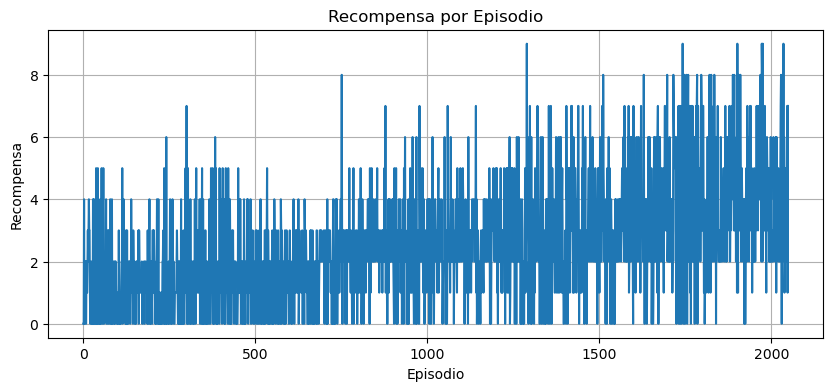

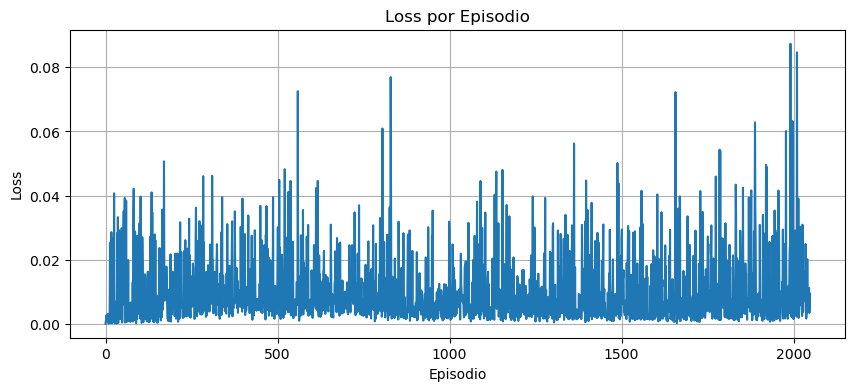

In [ ]:

PATHNAME = f"{COMMON_METRICS_PATH}{RUN_NAME}.npz"
graph_metrics(pathname=PATHNAME)

### Evaluamos el progreso del agente

In [ ]:
env = make_env(ENV_NAME,
                video_folder='./videos/dqn_validation/phase2',
                name_prefix="breakout",
                record_every=1,
                grayscale=GRAY_SCALE,
                screen_size=SCREEN_SIZE,
                stack_frames=NUM_STACKED_FRAMES,
                skip_frames=SKIP_FRAMES
                )

A.L.E: Arcade Learning Environment (version 0.10.2+unknown)
[Powered by Stella]
Game console created:
  ROM file:  /opt/anaconda3/envs/obl_taller_ia/lib/python3.12/site-packages/ale_py/roms/breakout.bin
  Cart Name: Breakout - Breakaway IV (1978) (Atari)
  Cart MD5:  f34f08e5eb96e500e851a80be3277a56
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is 1393104993


In [ ]:
dqn_agent.play(env, episodes=1)

env.close()

In [ ]:
env = make_env(ENV_NAME,
                video_folder='./videos/dqn_validation-2',
                name_prefix="breakout",
                record_every=1,
                grayscale=GRAY_SCALE,
                screen_size=SCREEN_SIZE,
                stack_frames=NUM_STACKED_FRAMES,
                skip_frames=SKIP_FRAMES
                )



A.L.E: Arcade Learning Environment (version 0.10.2+unknown)
[Powered by Stella]
Game console created:
  ROM file:  /opt/anaconda3/envs/obl_taller_ia/lib/python3.12/site-packages/ale_py/roms/breakout.bin
  Cart Name: Breakout - Breakaway IV (1978) (Atari)
  Cart MD5:  f34f08e5eb96e500e851a80be3277a56
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is 339480332


In [ ]:
dqn_agent.play(env, episodes=1)

env.close()

In [ ]:
# Ruta al archivo de v√≠deo en tu sistema de ficheros
video_path = "./videos/dqn_validation/phase2/breakout-episode-0.mp4"

# Muestra el v√≠deo
Video(video_path, embed=True, width=600)

## 4. Consolidaci√≥n y estabilidad de la pol√≠tica

Despu√©s de haber explorado el entorno y refinado algunas estrategias efectivas, el agente ya no act√∫a completamente a ciegas. Ha empezado a desarrollar comportamientos √∫tiles, y ahora es momento de **consolidar** ese conocimiento.

En esta tercera fase, extendemos el entrenamiento a **2.000.000 de pasos**, lo que permite al agente mejorar la consistencia de sus decisiones y adaptarse mejor a situaciones complejas del entorno.

En esta etapa, la exploraci√≥n es mucho m√°s moderada. El agente debe confiar cada vez m√°s en su pol√≠tica aprendida, pero a√∫n se le permite cierta libertad para seguir ajustando su comportamiento.

Configuramos el par√°metro `epsilon` as√≠:

- `EPSILON_INI = 0.1`: partimos de una exploraci√≥n baja, porque el agente ya tiene una base aprendida.
- `EPSILON_MIN = 0.01`: dejamos una peque√±a ventana de exploraci√≥n por si a√∫n puede descubrir mejores acciones.
- `EPSILON_ANNEAL_STEPS = 1.000.000`: el `epsilon` decae lentamente, permitiendo una transici√≥n gradual hacia la explotaci√≥n.

Durante esta fase **esperamos observar mejoras m√°s claras y sostenidas** en las m√©tricas:
- La recompensa promedio por episodio deber√≠a aumentar.
- El `loss` deber√≠a estabilizarse en valores m√°s bajos y menos ruidosos.
- El n√∫mero de pasos por episodio deber√≠a incrementarse, se√±al de que el agente sobrevive y act√∫a con mayor efectividad.

Esta fase marca el paso de un comportamiento inestable a una pol√≠tica m√°s **madura y confiable**, donde el agente deja de aprender por prueba y error, y empieza a actuar con intenci√≥n.

In [ ]:
TOTAL_STEPS = 2_000_000
EPISODES = 10_000
EPSILON_INI = 0.1
EPSILON_MIN = 0.01
EPSILON_ANNEAL_STEPS = 1_000_000

In [ ]:
PHASE = 'phase3'
VIDEO_FOLDER = f"./videos/dqn_training_{PHASE}"
env = create_env(video_folder=VIDEO_FOLDER)

A.L.E: Arcade Learning Environment (version 0.10.2+unknown)
[Powered by Stella]
Game console created:
  ROM file:  /opt/anaconda3/envs/obl_taller_ia/lib/python3.12/site-packages/ale_py/roms/breakout.bin
  Cart Name: Breakout - Breakaway IV (1978) (Atari)
  Cart MD5:  f34f08e5eb96e500e851a80be3277a56
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is -196329338


In [ ]:
# Creamos agente dqn
RUN_NAME=f"{PHASE}_run"
dqn_agent = load_dqn_agent(env,loadPath=PHASE2_MODEL_PATH, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, learning_rate=LEARNING_RATE, gamma=GAMMA, epsilon_i=EPSILON_INI, epsilon_f=EPSILON_MIN,epsilon_anneal_steps= EPSILON_ANNEAL_STEPS, episode_block=EPISODE_BLOCK, run_name=RUN_NAME)

In [ ]:
PHASE3_MODEL_PATH=f"{COMMON_MODEL_PATH}{PHASE}.dat"
dqn_rewards = dqn_agent.train(EPISODES, STEPS_PER_EPISODE, TOTAL_STEPS, PHASE3_MODEL_PATH)

env.close()

Entrenando:   0%|          | 0/10000 [00:00<?, ?episode/s]

Iniciando entrenamiento...


/opt/anaconda3/envs/obl_taller_ia/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/obl_taller_ia/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Entrenando:  15%|‚ñà‚ñå        | 1500/10000 [1:38:21<9:33:11,  4.05s/episode, reward=6.63, epsilon=0.055, steps=5e+5]    

Checkpoint guardado en GenericDQNAgent-steps:500244-e:0.05497804.dat


Entrenando:  27%|‚ñà‚ñà‚ñã       | 2724/10000 [3:16:22<12:09:10,  6.01s/episode, reward=8.84, epsilon=0.01, steps=1e+6]    

Checkpoint guardado en GenericDQNAgent-steps:1000300-e:0.01.dat


Entrenando:  37%|‚ñà‚ñà‚ñà‚ñã      | 3695/10000 [4:54:33<10:53:27,  6.22s/episode, reward=9.94, epsilon=0.01, steps=1.5e+6] 

Checkpoint guardado en GenericDQNAgent-steps:1500270-e:0.01.dat


Entrenando:  46%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 4593/10000 [6:32:47<7:42:24,  5.13s/episode, reward=12.1, epsilon=0.01, steps=2e+6]    

Entrenamiento detenido: se alcanzaron 2000001 pasos.
Checkpoint guardado en GenericDQNAgent-steps:2000001-e:0.01.dat


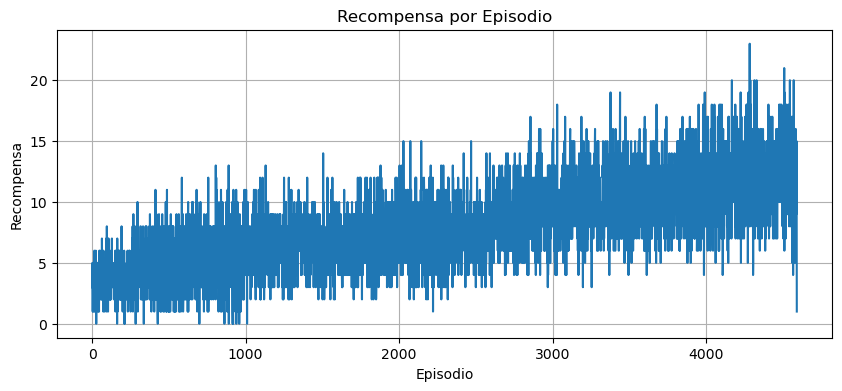

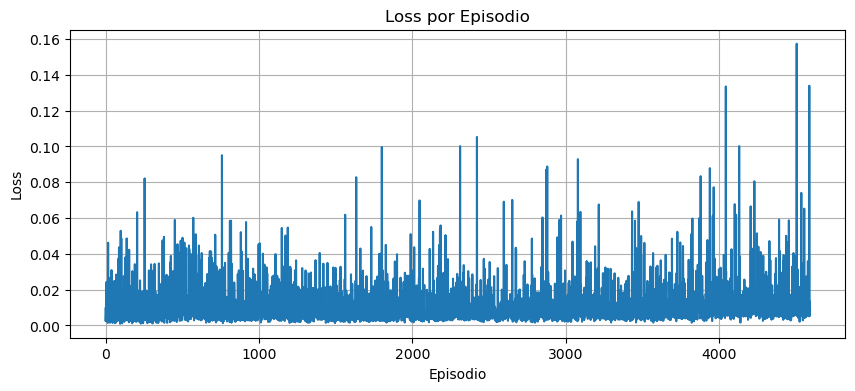

In [ ]:
graph_metrics(pathname="metrics/metrics_phase3_run.npz")

### Evaluar el juego del ambiente

In [ ]:
env = make_env(ENV_NAME,
                video_folder='./videos/dqn_validation/phase3',
                name_prefix="breakout",
                record_every=1,
                grayscale=GRAY_SCALE,
                screen_size=SCREEN_SIZE,
                stack_frames=NUM_STACKED_FRAMES,
                skip_frames=SKIP_FRAMES
                )

A.L.E: Arcade Learning Environment (version 0.10.2+unknown)
[Powered by Stella]
Game console created:
  ROM file:  /opt/anaconda3/envs/obl_taller_ia/lib/python3.12/site-packages/ale_py/roms/breakout.bin
  Cart Name: Breakout - Breakaway IV (1978) (Atari)
  Cart MD5:  f34f08e5eb96e500e851a80be3277a56
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is -1028027523


In [ ]:
dqn_agent.play(env, episodes=1)

env.close()

In [ ]:
# Ruta al archivo de v√≠deo en tu sistema de ficheros
video_path = "./videos/dqn_validation/phase3/breakout-episode-0.mp4"

# Muestra el v√≠deo
Video(video_path, embed=True, width=600)

## 5. Entrenamiento largo

Luego de consolidar una pol√≠tica estable, el agente est√° listo para enfrentar su fase m√°s extensa: **un entrenamiento de 7.000.000 pasos**. Esta etapa tiene como objetivo principal **refinar los √∫ltimos detalles de su comportamiento**, buscando alcanzar un rendimiento √≥ptimo y robusto.

Durante esta fase, la exploraci√≥n es m√≠nima:

- `EPSILON_INI = 0.05`: el agente comienza confiando casi por completo en su pol√≠tica aprendida.
- `EPSILON_MIN = 0.01`: se conserva un margen muy peque√±o de exploraci√≥n para evitar caer en pol√≠ticas r√≠gidas o locales.
- `EPSILON_ANNEAL_STEPS = 1.000.000`: el descenso es lento y progresivo, asegurando una transici√≥n estable hacia la explotaci√≥n total.

En este punto, el agente ya sabe jugar razonablemente bien. El objetivo no es descubrir nuevas estrategias, sino **mejorar la consistencia, evitar errores espor√°dicos** y adaptarse a variaciones sutiles del entorno.

En la gr√°fica de p√©rdida (loss), esperamos observar:

- Valores bajos de p√©rdida sostenida, con menor varianza.
- Posibles picos aislados, que reflejan casos complejos o poco frecuentes.
- Una mayor proporci√≥n de episodios con `loss` cercano a cero.

Esta etapa representa el momento en que el agente deja de aprender con grandes saltos y empieza a **pulir detalles**, como quien afina los √∫ltimos toques antes de una presentaci√≥n.

Al final de esta fase, esperamos ver un comportamiento mucho m√°s **confiado, efectivo y repetible**, listo para ser evaluado sin exploraci√≥n y con resultados competitivos.

In [ ]:
TOTAL_STEPS = 2_000_000
EPISODES = 10_000
EPSILON_INI = 0.01
EPSILON_MIN = 0.01
EPSILON_ANNEAL_STEPS = 1_000_000

In [ ]:
PHASE = 'phase4'
VIDEO_FOLDER = f"./videos/dqn_training_{PHASE}"
env = create_env(video_folder=VIDEO_FOLDER)

A.L.E: Arcade Learning Environment (version 0.10.2+unknown)
[Powered by Stella]
Game console created:
  ROM file:  /opt/anaconda3/envs/obl_taller_ia/lib/python3.12/site-packages/ale_py/roms/breakout.bin
  Cart Name: Breakout - Breakaway IV (1978) (Atari)
  Cart MD5:  f34f08e5eb96e500e851a80be3277a56
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is -38645947
/opt/anaconda3/envs/obl_taller_ia/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /Users/reichelort/Desktop/Taller_AI/Obligatorio final/obligatorio-taller-ia/videos/dqn_training_phase4 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [ ]:
# Creamos agente dqn
RUN_NAME=f"{PHASE}_run"
dqn_agent = load_dqn_agent(env,loadPath=PHASE3_MODEL_PATH, buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, learning_rate=LEARNING_RATE, gamma=GAMMA, epsilon_i=EPSILON_INI, epsilon_f=EPSILON_MIN,epsilon_anneal_steps= EPSILON_ANNEAL_STEPS, episode_block=EPISODE_BLOCK, run_name=RUN_NAME)

In [ ]:
PHASE4_MODEL_PATH=f"{COMMON_MODEL_PATH}{PHASE}.dat"
dqn_rewards = dqn_agent.train(EPISODES, STEPS_PER_EPISODE, TOTAL_STEPS, PHASE4_MODEL_PATH)

env.close()

In [ ]:
net.load_state_dict(torch.load(PHASE4_MODEL_PATH))

<All keys matched successfully>

In [ ]:
env = make_env(ENV_NAME,
                video_folder='./videos/dqn_validation/phase4-2',
                name_prefix="breakout",
                record_every=1,
                grayscale=GRAY_SCALE,
                screen_size=SCREEN_SIZE,
                stack_frames=NUM_STACKED_FRAMES,
                skip_frames=SKIP_FRAMES
                )

A.L.E: Arcade Learning Environment (version 0.10.2+unknown)
[Powered by Stella]
Game console created:
  ROM file:  /opt/anaconda3/envs/obl_taller_ia/lib/python3.12/site-packages/ale_py/roms/breakout.bin
  Cart Name: Breakout - Breakaway IV (1978) (Atari)
  Cart MD5:  f34f08e5eb96e500e851a80be3277a56
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is 491569105


In [ ]:
dqn_agent.play(env, episodes=1)

env.close()

In [ ]:
# Ruta al archivo de v√≠deo en tu sistema de ficheros
video_path = "./videos/dqn_validation/phase4/breakout-episode-0.mp4"

# Muestra el v√≠deo
Video(video_path, embed=True, width=600)

#### Graficas 
...

# Double Deep Q Learning

Double DQN mejora la versi√≥n cl√°sica de DQN corrigiendo el sesgo de sobreestimaci√≥n de los valores 
ùëÑ
Q. Para ello, desacopla la selecci√≥n de la acci√≥n de su evaluaci√≥n: en cada paso, la red online elige la acci√≥n que maximiza 
ùëÑ
Q, pero la red objetivo distinta estima el valor de esa acci√≥n. Esta separaci√≥n reduce el sesgo hacia valores demasiado optimistas y aporta mayor estabilidad al entrenamiento. El resto de la estructura ‚Äîreplay buffer, pol√≠tica Œµ-greedy, etc‚Äî se mantiene igual que en DQN, aprovechando as√≠ un dise√±o casi id√©ntico al original pero con resultados m√°s fiables .

Fuente: [arXiv:1509.06461](https://arxiv.org/abs/1509.06461)

> Vamos a utilizar el mismo modelo de red neuronal creado para el problema anterior y la misma implementaci√≥n de memoria, dejamos un esqueleto de un agente de Double Deep Q learning para completar en el archivo **double_dqn_agent.py**

In [ ]:
from double_dqn_agent import DoubleDQNAgent

env = make_env(ENV_NAME,
                video_folder='./videos/ddqn_training',
                name_prefix="breakout",
                record_every=500,
                grayscale=GRAY_SCALE,
                screen_size=SCREEN_SIZE,
                stack_frames=NUM_STACKED_FRAMES,
                skip_frames=SKIP_FRAMES
                )


modelo_a = DQN_CNN_Model(env.observation_space.shape, env.action_space.n).to(DEVICE)
modelo_b = DQN_CNN_Model(env.observation_space.shape, env.action_space.n).to(DEVICE)

ddqn_agent = DoubleDQNAgent(env, modelo_a, modelo_b, process_state, BUFFER_SIZE, BATCH_SIZE, LEARNING_RATE, GAMMA, epsilon_i= EPSILON_INI, epsilon_f=EPSILON_MIN, epsilon_anneal_steps=EPSILON_ANNEAL_STEPS, episode_block = EPISODE_BLOCK, device=DEVICE)

ddqn_rewards = ddqn_agent.train(EPISODES, STEPS_PER_EPISODE, TOTAL_STEPS)

Output shape before conv1: (84, 84)
Output shape after conv1: (20, 20)
Output shape after conv2: (9, 9)
Output shape before conv1: (84, 84)
Output shape after conv1: (20, 20)
Output shape after conv2: (9, 9)


Entrenando:   0%|          | 0/10000 [00:00<?, ?episode/s]


TypeError: list indices must be integers or slices, not NoneType

In [ ]:
env = make_env(ENV_NAME,
                video_folder='./videos/ddqn_validation',
                name_prefix="breakout",
                record_every=1,
                grayscale=GRAY_SCALE,
                screen_size=SCREEN_SIZE,
                stack_frames=NUM_STACKED_FRAMES,
                skip_frames=SKIP_FRAMES
                )

ddqn_agent.play(env, episodes=3)

env.close()

In [ ]:
# Ruta al archivo de v√≠deo en tu sistema de ficheros
video_path = "./videos/ddqn_validation/breakout-episode-0.mp4"

# Muestra el v√≠deo
Video(video_path, embed=True, width=600)

#### Graficas 
...

# Experimentaci√≥n
Aqu√≠ con libertad total, pueden probar diferentes arquitecturas de red, diferentes hiperpar√°metros, diferentes t√©cnicas de exploraci√≥n, etc.
...

# Comparaciones, Resultados, Comentarios...
De aqu√≠ en adelante son libres de presentar como gusten los resultados comparativos de las t√©cnicas.
...